In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# #pra receber os dadoss

# try:
#     print("Carregando dados...")
#     ENDERECO_DADOS = 'https://www.ispdados.rj.gov.br/Arquivos/BaseDPEvolucaoMensalCisp.csv'
#     df = pd.read_csv(ENDERECO_DADOS, sep=';', encoding='iso-8859-1') #  pra corrigir os dados
#     # determmina as colunas relevantes e converter para datetime
#     df['mes_ano'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str))
#     #junta por trimestre
#     df_trimestral = df.groupby(pd.PeriodIndex(df['mes_ano'], freq='Q'))[['lesao_corp_dolosa', 'lesao_corp_morte']].sum().reset_index()
#     print('\nDados trimestrais:')
#     print(df_trimestral.head())
#     print('\nEstatisticas descritivas:')
#     print(df_trimestral.describe())
# except Exception as e:
#     print("Erro ao carregar os dados:", {e})
#     exit()


In [ ]:
# # 2. Análise de Correlação
# try:
#     print('\nCalculando correlação...')
    
#     correlacao = np.corrcoef(df_trimestral['lesoes_dolosas'], 
#                             df_trimestral['lesoes_morte'])[0,1]
    
#     print(f'Correlação Pearson entre lesões dolosas e com morte: {correlacao:.3f}')
    
#     # Gráfico de dispersão
#     plt.figure(figsize=(10,6))
#     plt.scatter(df_trimestral['lesoes_dolosas'], 
#                 df_trimestral['lesoes_morte'],
#                 alpha=0.7)
#     plt.title(f'Relação entre Lesões Dolosas e com Morte (Correlação: {correlacao:.3f})')
#     plt.xlabel('Lesões Dolosas (3 meses)')
#     plt.ylabel('Lesões com Morte (3 meses)')
#     plt.grid(True)
#     plt.show()
    
# except Exception as e:
#     print(f'Erro na análise de correlação: {e}')
#     exit()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Configuração para evitar warnings
pd.set_option('mode.chained_assignment', None)


In [2]:
# 1. Obter e preparar os dados (com mais verificações)
try:
    print('1/4: Obtendo dados históricos...')
    
    ENDERECO_DADOS = 'https://www.ispdados.rj.gov.br/Arquivos/BaseDPEvolucaoMensalCisp.csv'
    
    # Carregar com tratamento de erro específico
    try:
        df = pd.read_csv(ENDERECO_DADOS, sep=';', encoding='iso-8859-1', on_bad_lines='warn')
    except Exception as e:
        print(f'Erro ao ler CSV: {e}')
        # Tentar fallback para outro encoding
        df = pd.read_csv(ENDERECO_DADOS, sep=';', encoding='cp1252', on_bad_lines='warn')
    
    # Verificar se as colunas necessárias existem
    colunas_necessarias = ['ano', 'mes', 'lesao_corp_dolosa', 'lesao_corp_morte']
    if not all(col in df.columns for col in colunas_necessarias):
        missing = [col for col in colunas_necessarias if col not in df.columns]
        raise ValueError(f'Colunas faltantes: {missing}')
    
    # Converter para trimestral com verificações
    df['mes_ano'] = pd.to_datetime(df['ano'].astype(str) + '-' + df['mes'].astype(str), errors='coerce')
    if df['mes_ano'].isnull().any():
        print('Aviso: Algumas datas não puderam ser convertidas e serão removidas')
        df = df.dropna(subset=['mes_ano'])
    
    df_trimestral = df.groupby(pd.PeriodIndex(df['mes_ano'], freq='Q'))[
        ['lesao_corp_dolosa', 'lesao_corp_morte']].sum().reset_index()
    
    # Verificar se há dados suficientes
    if len(df_trimestral) < 3:
        raise ValueError('Dados insuficientes para análise (menos de 3 trimestres)')
    
    df_trimestral.columns = ['trimestre', 'lesoes_dolosas', 'lesoes_morte']
    
    print('\nAmostra dos dados:')
    print(df_trimestral.head())
    
except Exception as e:
    print(f'FALHA NA ETAPA 1: {str(e)}')
    if 'df' in locals():
        print('\nDebug: Colunas disponíveis:', df.columns.tolist())
    exit()

1/4: Obtendo dados históricos...

Amostra dos dados:
  trimestre  lesoes_dolosas  lesoes_morte
0    2003Q1           20963            15
1    2003Q2           18585            19
2    2003Q3           17991            16
3    2003Q4           20689             6
4    2004Q1           19470            10



2/4: Calculando correlação...
Aviso: 2 outliers removidos
Correlação Pearson: -0.030


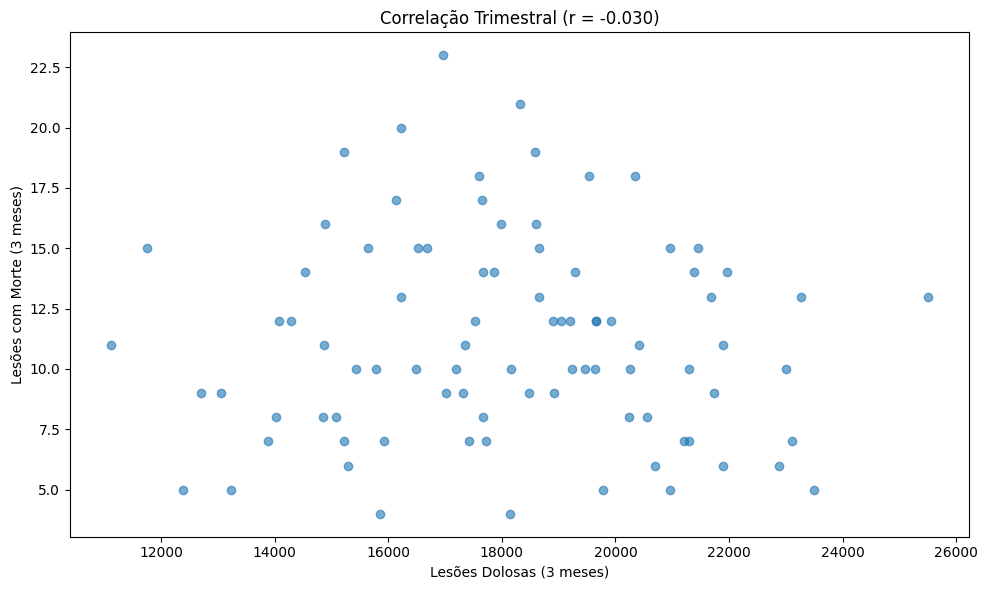

In [3]:
# 2. Análise de Correlação (com mais verificações)
try:
    print('\n2/4: Calculando correlação...')
    
    # Verificar zeros ou valores absurdos
    if (df_trimestral['lesoes_dolosas'] == 0).any() or (df_trimestral['lesoes_morte'] == 0).any():
        print('Aviso: Zeros encontrados nos dados - isso pode afetar a análise')
    
    # Remover outliers extremos (opcional)
    q1 = df_trimestral[['lesoes_dolosas', 'lesoes_morte']].quantile(0.25)
    q3 = df_trimestral[['lesoes_dolosas', 'lesoes_morte']].quantile(0.75)
    iqr = q3 - q1
    
    filtro = ~((df_trimestral[['lesoes_dolosas', 'lesoes_morte']] < (q1 - 1.5*iqr)) | 
              (df_trimestral[['lesoes_dolosas', 'lesoes_morte']] > (q3 + 1.5*iqr))).any(axis=1)
    df_filtrado = df_trimestral[filtro]
    
    if len(df_filtrado) < len(df_trimestral):
        print(f'Aviso: {len(df_trimestral) - len(df_filtrado)} outliers removidos')
    
    # Calcular correlação
    correlacao = np.corrcoef(df_filtrado['lesoes_dolosas'], df_filtrado['lesoes_morte'])[0,1]
    print(f'Correlação Pearson: {correlacao:.3f}')
    
    # Plotar com tamanho controlado
    plt.figure(figsize=(10,6), dpi=100)  # Reduzir DPI se necessário
    plt.scatter(df_filtrado['lesoes_dolosas'], df_filtrado['lesoes_morte'], alpha=0.6)
    plt.title(f'Correlação Trimestral (r = {correlacao:.3f})')
    plt.xlabel('Lesões Dolosas (3 meses)')
    plt.ylabel('Lesões com Morte (3 meses)')
    plt.tight_layout()  # Prevenir cortes
    plt.show()
    
except Exception as e:
    print(f'FALHA NA ETAPA 2: {str(e)}')
    if 'df_trimestral' in locals():
        print('\nDebug - Estatísticas:\n', df_trimestral.describe())
    exit()


3/4: Criando modelo...
Coeficiente R²: 0.001
Aviso: O modelo explica menos de 30% da variância

Previsões para próximos trimestres:
- 40000 lesões dolosas → 10.3 lesões com morte previstas
- 50000 lesões dolosas → 9.9 lesões com morte previstas
- 60000 lesões dolosas → 9.5 lesões com morte previstas


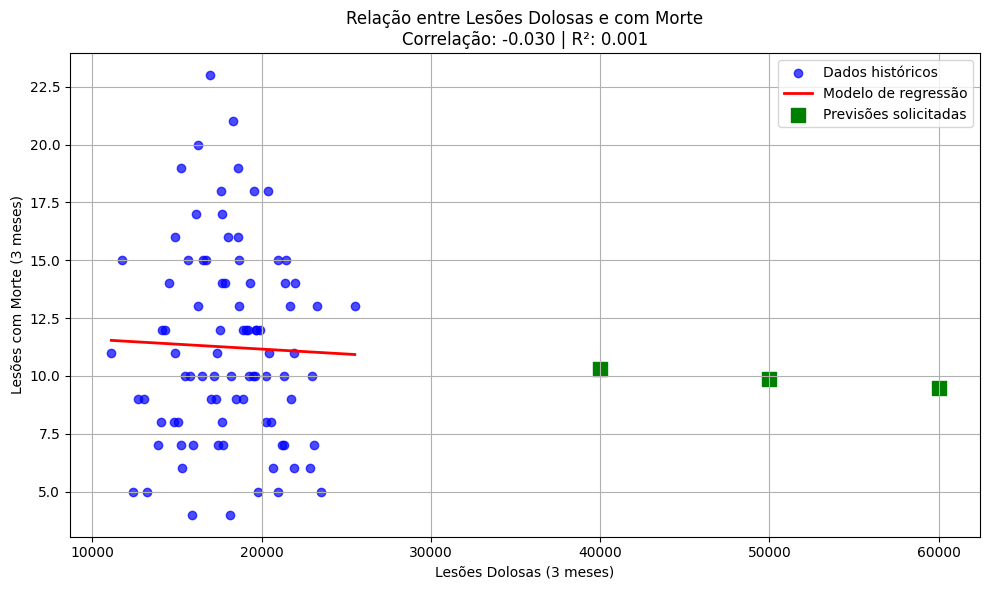


4/4: Análise concluída com sucesso!


In [4]:
# 3. Modelagem e Previsões (com validação)
try:
    print('\n3/4: Criando modelo...')
    
    X = df_filtrado[['lesoes_dolosas']].values
    y = df_filtrado['lesoes_morte'].values
    
    # Validar dados
    if len(X) < 2:
        raise ValueError('Dados insuficientes após filtragem')
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    
    # Validar modelo
    r2 = modelo.score(X, y)
    print(f'Coeficiente R²: {r2:.3f}')
    if r2 < 0.3:
        print('Aviso: O modelo explica menos de 30% da variância')
    
    # Previsões
    cenarios = [[40000], [50000], [60000]]
    previsoes = modelo.predict(cenarios)
    
    print('\nPrevisões para próximos trimestres:')
    for cenario, prev in zip(cenarios, previsoes):
        print(f'- {cenario[0]} lesões dolosas → {prev:.1f} lesões com morte previstas')
    
    # Plot com dados e previsões
    plt.figure(figsize=(10,6))
    
    # Dados reais
    plt.scatter(X, y, color='blue', alpha=0.7, label='Dados históricos')
    
    # Linha de regressão
    x_range = np.linspace(X.min(), X.max(), 100)
    plt.plot(x_range, modelo.predict(x_range.reshape(-1,1)), 
             color='red', linewidth=2, label='Modelo de regressão')
    
    # Previsões
    plt.scatter(cenarios, previsoes, color='green', s=100, marker='s', 
               label='Previsões solicitadas')
    
    plt.title('Relação entre Lesões Dolosas e com Morte\n' + 
             f'Correlação: {correlacao:.3f} | R²: {r2:.3f}')
    plt.xlabel('Lesões Dolosas (3 meses)')
    plt.ylabel('Lesões com Morte (3 meses)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f'FALHA NA ETAPA 3: {str(e)}')
    if 'modelo' in locals():
        print('\nDebug - Coeficientes:', modelo.coef_)
    exit()

print('\n4/4: Análise concluída com sucesso!')